## Model Architecture
### 10 epochs

In [1]:
import os
import pathlib
import random

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


import tensorflow as tf
from tensorflow.keras.callbacks import Callback

from tensorflow.keras.utils import Sequence
from keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import (Conv2D,
                                     Flatten,
                                     Activation,
                                     Dense, 
                                     BatchNormalization, 
                                     Dropout,
                                    LeakyReLU)

from keras_vggface.vggface import VGGFace

mixed_precision.set_global_policy('mixed_float16')


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660 Ti, compute capability 7.5


## Read Data 

## Reading Data

In [2]:
BASE_PATH = r'D:\Project\Dataset'
DATA_PATH = os.path.join(BASE_PATH, 'replay-mobile_image')

TRAIN_FILE_PATH = "train.txt"
# TEST_FILE_PATH = "test_private_list.txt"
# VAL_FILE_PATH = "val_private_list.txt"
# REAL_FILE_PATH = "real_data.txt"
MODEL_PATH = "models"

RESIZE_CROP = (256, 256)

BATCH_SIZE = 32

TRAIN, VAL, TEST = 0.8, 0.1, 0.2


In [3]:
# path = r"C:\Users\hp\Desktop\Project\Dataset\CASIA-SURF-Challenge\Testing"
# test_files = []
# for root, dirs, files in os.walk(path):
#     if files:
#         for file in files:
#             if file.endswith("color.jpg"):
#                 test_files.append(os.path.join(root, file))

                

In [4]:
# path = r"C:\Users\hp\Desktop\Project\Dataset\CASIA-SURF-Challenge\Val"
# for root, dirs, files in os.walk(path):
#     if files:
#         for file in files:
#             if file.endswith("color.jpg"):
#                 test_files.append(os.path.join(root, file))


In [5]:
# data = []
# for root, dirs, files in os.walk(DATA_PATH):
#     if files:
#         for file in files:
#             data.append(os.path.join(root, file))
            
# with open(os.path.join(DATA_PATH, "train.txt"), "w") as f:
#     for line in data:
#         f.write(line+"\n")

In [6]:

TRAIN_FILES = os.path.join(DATA_PATH, TRAIN_FILE_PATH)
# TEST_FILES = os.path.join(DATA_PATH, TEST_FILE_PATH)
# VAL_FILES = os.path.join(DATA_PATH, VAL_FILE_PATH)
# REAL_FILES = os.path.join(DATA_PATH, REAL_FILE_PATH)

def read_file(file):
    data_paths = []
    with open(file, 'r') as f:
        while True:
            
            line = f.readline()
            if len(line) == 0:
                break
            line = line.split(" ")[0]
            data_paths.append(line[:-1])
            
    return data_paths



train_abs_paths = read_file(TRAIN_FILES)
# real_abs_paths  = read_file(REAL_FILES)
# with open(REAL_FILES, "r") as f:
#     lines = f.readlines()
#     lines = [line[:-1] for line in lines]
# Read Augmented
# with open("augmented_image_paths.txt", "r") as f:
#     augmented_data_path = f.readlines()
#     augmented_data_path = [path[:-1] for path in augmented_data_path]

# Data with not Label
# test_abs_paths = read_file(TEST_FILES)
# val_abs_paths = read_file(VAL_FILES)
# train_abs_paths  = train_abs_paths + augmented_data_path
# train_abs_paths = train_abs_paths + lines
# train_abs_paths = train_abs_paths + augmented_data_path
print(f"Number of train samples : {len(train_abs_paths)}")
print(train_abs_paths[0])

Number of train samples : 13308
D:\Project\Dataset\replay-mobile_image\train\attack\devel_0000_0.jpg


In [7]:
def split_fake_real(data):
    data_splited = [path.split('\\') for path in data]
    data_splited = ['real' in _ for _ in data_splited]
    real_index = data_splited.index(True)
    labels = [0] * real_index + [1] * (len(data) - real_index)
    return labels

In [8]:
def read_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype='float32')
    image = tf.image.resize(image, size=RESIZE_CROP)
    return image

In [9]:
train_Y = split_fake_real(train_abs_paths)
train_X = [os.path.join(DATA_PATH, image_path) for image_path in train_abs_paths]
real_number = sum(train_Y)
real_percentage = sum(train_Y)*100 / len(train_Y)

fake_number = len(train_Y) - real_number
fake_percentage = 100 - real_percentage
print(f"Number of Real images : {real_number}")
print(f"Percentage of Real images : %{real_percentage:.2f}")
print("-----------------------------------")
print(f"Number of Fake images : {fake_number}")
print(f"Percentage of Fake images : %{fake_percentage:.2f}")
train_X[6434]

Number of Real images : 6874
Percentage of Real images : %51.65
-----------------------------------
Number of Fake images : 6434
Percentage of Fake images : %48.35


'D:\\Project\\Dataset\\replay-mobile_image\\train\\real\\augmented_devel_0000_2578.jpg'

In [10]:
# Define augmentation functions
def random_flip(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

def random_brightness(image, label):
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

def random_contrast(image, label):
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

def random_rotate_small(image, label, max_angle=15):
    angle = tf.random.uniform(shape=[], minval=-max_angle, maxval=max_angle, dtype=tf.float32)
    image = tf.image.rot90(image, tf.cast(angle / 90, tf.int32))
    return image, label

# Define augmentation pipeline for label 1 (fake images)
def apply_augmentation(image, label):
    if label == 1:
        image, label = random_flip(image, label)
        image, label = random_brightness(image, label)
        image, label = random_contrast(image, label)
        image, label = random_rotate_small(image, label)
    return image, label

### Apply augmentation on Real Data


In [11]:
# with open("augmented_image_paths.txt", 'r') as f:
#     data = f.readlines()

# with open("augmented_image_paths.txt", 'w') as f:
#     for path in data:
#         f.write(path.replace("C:\\Users\\hp\\Desktop\\Project\\Dataset\\CASIA-SURF-Challenge\\", ""))

In [12]:

# # Assuming you have already defined the augmentation functions as before...

# # List of file paths to your train images (without the common prefix)
# real_image_paths = train_X[20324:]

# # Function to read and augment an image from the file path
# def read_and_augment_image(image_path):
#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_jpeg(image, channels=3)  # You can also use decode_png() if images are in PNG format
#     image, _ = apply_augmentation(image, label=1)  # Assuming label=1 for real images
#     return image

# # Function to save the augmented image back to the same file path with "augmented" in the name
# def save_augmented_image(image, image_path):
#     base_dir = os.path.dirname(image_path)
#     base_name = os.path.basename(image_path)
#     augmented_base_name = "augmented_" + base_name
#     augmented_image_path = os.path.join(base_dir, augmented_base_name)
    
#     if os.path.exists(augmented_image_path):
#         print(f"Augmented version of {image_path} already exists. Skipping...")
#         return augmented_image_path
    
#     encoded_image = tf.image.encode_jpeg(tf.cast(image, tf.uint8))  # You can use encode_png() for PNG format
#     tf.io.write_file(augmented_image_path, encoded_image)

#     return augmented_image_path

# # Create a list to store the paths of all augmented images
# augmented_image_paths = []

# # Loop over each real image path, read, augment, and save back with "augmented" in the name
# for real_image_path in real_image_paths:
#     augmented_image = read_and_augment_image(real_image_path)
#     augmented_image_path = save_augmented_image(augmented_image, real_image_path)
#     augmented_image_paths.append(augmented_image_path)

# # Remove the common prefix from each path
# common_prefix = "C:Users/hp/Desktop/Project/Dataset/CASIA-SURF-Challenge/"
# augmented_image_paths_relative = [path.replace(common_prefix, "") for path in augmented_image_paths]

# # Save the paths of augmented images to the txt file without the common prefix
# txt_file_path = "augmented_image_paths.txt"
# with open(txt_file_path, 'w') as file:
#     for path in augmented_image_paths_relative:
#         file.write(path + '\n')

# print("Augmentation and save completed.")


In [13]:
train_x, test_x, train_y, test_y = train_test_split(train_X, train_Y, test_size=TEST, shuffle=True)
# # The validation and test data is not labeled so we use train part
# test_x_path = [os.path.join(DATA_PATH, image_path) for image_path in test_abs_paths]
# val_x_path = [os.path.join(DATA_PATH, image_path) for image_path in val_abs_paths]
print(f"Number train data : {len(train_x)}")
print(f"Number test data : {len(test_x)}")

Number train data : 10646
Number test data : 2662


In [14]:
with open("testx_5.txt", "w") as f:
    for path in test_x:
        f.write(path + "\n")
        
with open("testy_5.txt", "w") as f:
    for path in test_y:
        f.write(str(path) + "\n")

In [15]:
print(f"Real data in train : {sum(train_y)}")
print(f"Fake data in train : {len(train_y) - sum(train_y)}")

Real data in train : 5506
Fake data in train : 5140


#### Ploting some of train images


Images size : (256, 256, 3)


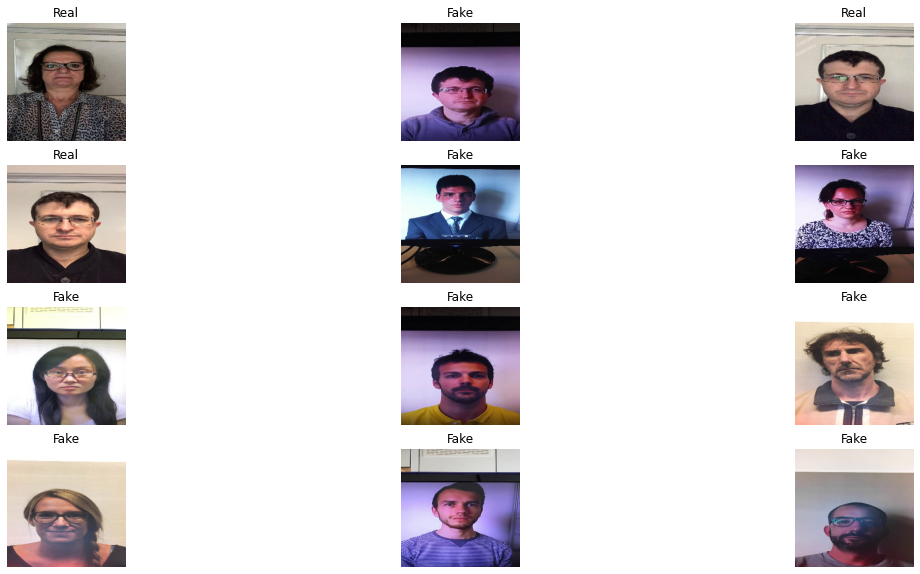

In [16]:
num_image = 12
rows = 4
column = 3

figs, axes = plt.subplots(rows, column, figsize=(20, 10))

axes = axes.ravel()

for i in range(num_image):
    img = random.choice(train_x)
    label = train_y[train_x.index(img)]
    img = read_image(img)
    label = "Real" if label else "Fake"
    axes[i].imshow(img)
    axes[i].set_title(label, fontsize=12)
    axes[i].axis("off")
print(f"Images size : {img.shape}")

plt.show()

## 

In [17]:
# Used this
def generator(images, labels):
    idx = np.arange(len(images))
    for i in idx:
        yield (read_image(images[i]), labels[i])

In [18]:


test_dataset = tf.data.Dataset.from_generator(
            lambda : generator(test_x, test_y),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
)

## Model Architecture

In [19]:
performance_scores = []

# Define the number of folds (k)
K = 5

# Initialize the k-fold cross-validator
kf = KFold(n_splits=K, shuffle=True, random_state=42)
folds = kf.split(train_x, train_y)

# Model Architecture
IMG_SIZE = (256, 256)

IMG_SHAPE = IMG_SIZE + (3,)


In [20]:
performance_scores = []

### Model 1


In [21]:
# FOLD 1
train_index, val_index = next(folds)
print(train_index[:10])
print(val_index[:10])

[ 1  2  4  5  6  7  9 11 12 13]
[ 0  3  8 10 14 19 23 29 31 33]


In [22]:
X_train, X_val = [train_x[i] for i in train_index], [train_x[i] for i in val_index]
y_train, y_val = [train_y[i] for i in train_index], [train_y[i] for i in val_index]
train_dataset_1 = tf.data.Dataset.from_generator(
            lambda : generator(X_train, y_train),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
)

val_dataset_1 =  tf.data.Dataset.from_generator(
            lambda : generator(X_val, y_val),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
)

In [23]:

base_model_1 = VGGFace(input_shape=IMG_SHAPE, include_top=False, model='resnet50')
print(f"Number of layers in VGGFACE : {len(base_model_1.layers)}")

len(base_model_1.layers)
base_model_1.trainable = False

# fine_tune_from_layer = 16
for layer in base_model_1.layers[-30:]:
    layer.trainable = True
#     print(layer)


Number of layers in VGGFACE : 174


In [24]:


model_1 = Sequential()
model_1.add(base_model_1)
model_1.add(Flatten())

model_1.add(Dense(1024, activation='relu'))  # Fully connected layer
model_1.add(BatchNormalization())
model_1.add(Dropout(0.2))

model_1.add(Dense(512, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_1.add(BatchNormalization())
model_1.add(Dropout(0.2))

model_1.add(Dense(256, activation='relu'))  # Fully connected layer
model_1.add(BatchNormalization())
model_1.add(Dropout(0.2))

model_1.add(Dense(128, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_1.add(BatchNormalization())


model_1.add(Dense(1, activation='sigmoid'))
model_1.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'])

base_model_1.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 128, 128, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 128, 128, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

In [25]:
# metrics_callback_1 = MetricsCallback(val_dataset_1.batch(BATCH_SIZE).prefetch(3))
early_stopping_1 = EarlyStopping(patience=5, restore_best_weights=True)

history_1 = model_1.fit(train_dataset_1.batch(BATCH_SIZE).prefetch(3).repeat(),
                    steps_per_epoch=int(len(X_train) // BATCH_SIZE),
                    epochs=15,
                    verbose=1,
                    validation_data=val_dataset_1.batch(BATCH_SIZE).prefetch(3).repeat(),
                    validation_steps=int(len(X_val) // BATCH_SIZE),
                    use_multiprocessing=True,
                    callbacks=[early_stopping_1]
                    )

Epoch 1/15
266/266 [==============================] - 300s 1s/step - loss: 0.1116 - accuracy: 0.9590 - val_loss: 0.7626 - val_accuracy: 0.5047
Epoch 2/15
266/266 [==============================] - 95s 358ms/step - loss: 0.0234 - accuracy: 0.9941 - val_loss: 0.1560 - val_accuracy: 0.9318
Epoch 3/15
266/266 [==============================] - 95s 358ms/step - loss: 0.0136 - accuracy: 0.9959 - val_loss: 0.0107 - val_accuracy: 0.9972
Epoch 4/15
266/266 [==============================] - 94s 355ms/step - loss: 0.0072 - accuracy: 0.9985 - val_loss: 0.0013 - val_accuracy: 0.9995
Epoch 5/15
266/266 [==============================] - 97s 365ms/step - loss: 0.0059 - accuracy: 0.9983 - val_loss: 0.2186 - val_accuracy: 0.9228
Epoch 6/15
266/266 [==============================] - 97s 366ms/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 0.0046 - val_accuracy: 0.9972
Epoch 7/15
266/266 [==============================] - 97s 366ms/step - loss: 0.0032 - accuracy: 0.9992 - val_loss: 0.0081 - val_accu

In [26]:
loss_1, accuracy_1 = model_1.evaluate(test_dataset.batch(BATCH_SIZE).prefetch(3))
performance_scores.append(accuracy_1)

84/84 [==============================] - 75s 890ms/step - loss: 2.3180e-04 - accuracy: 1.0000


In [27]:
model_1.save("models/model_1_replay_resnet_train")
model_1.save_weights("models/model_1_replay_renet_train")

C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: models/model_1_replay_resnet_train\assets


INFO:tensorflow:Assets written to: models/model_1_replay_resnet_train\assets


### Model 2


In [78]:
# FOLD 2
train_index, val_index = next(folds)
print(train_index[:10])
print(val_index[:10])

[0 1 2 3 4 5 6 7 8 9]
[12 17 20 26 30 37 41 45 46 48]


In [79]:
X_train, X_val = [train_x[i] for i in train_index], [train_x[i] for i in val_index]
y_train, y_val = [train_y[i] for i in train_index], [train_y[i] for i in val_index]
train_dataset_2 = tf.data.Dataset.from_generator(
            lambda : generator(X_train, y_train),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
)

val_dataset_2 =  tf.data.Dataset.from_generator(
            lambda : generator(X_val, y_val),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
)

In [80]:

base_model_2 = VGGFace(input_shape=IMG_SHAPE, include_top=False, model='resnet50')
print(f"Number of layers in VGGFACE : {len(base_model_2.layers)}")

len(base_model_2.layers)
base_model_2.trainable = False

fine_tune_from_layer = 16
for layer in base_model_2.layers[-30:]:
    layer.trainable = True


model_2 = Sequential()
model_2.add(base_model_2)
model_2.add(Flatten())
model_2.add(Dense(1024, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_2.add(BatchNormalization())
model_2.add(Dropout(0.2))

model_2.add(Dense(512, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_2.add(BatchNormalization())
model_2.add(Dropout(0.2))

model_2.add(Dense(256, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_2.add(BatchNormalization())
model_2.add(Dropout(0.2))

model_2.add(Dense(128, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_2.add(BatchNormalization())


model_2.add(Dense(1, activation='sigmoid'))
model_2.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'])



Number of layers in VGGFACE : 174


In [81]:
# metrics_callback_1 = MetricsCallback(val_dataset_1.batch(BATCH_SIZE).prefetch(3))
early_stopping_2 = EarlyStopping(patience=5, restore_best_weights=True)

history_2 = model_2.fit(train_dataset_2.batch(BATCH_SIZE).prefetch(3).repeat(),
                    steps_per_epoch=int(len(X_train) // BATCH_SIZE),
                    epochs=10,
                    verbose=1,
                    validation_data=val_dataset_2.batch(BATCH_SIZE).prefetch(3).repeat(),
                    validation_steps=int(len(X_val) // BATCH_SIZE),
                    use_multiprocessing=True,
                    callbacks=[early_stopping_2]
                    )

Epoch 1/10
266/266 [==============================] - 131s 474ms/step - loss: 0.0997 - accuracy: 0.9652 - val_loss: 0.6565 - val_accuracy: 0.5455
Epoch 2/10
266/266 [==============================] - 100s 375ms/step - loss: 0.0203 - accuracy: 0.9949 - val_loss: 0.3740 - val_accuracy: 0.8187
Epoch 3/10
266/266 [==============================] - 96s 363ms/step - loss: 0.0099 - accuracy: 0.9971 - val_loss: 1.5786 - val_accuracy: 0.6406
Epoch 4/10
266/266 [==============================] - 96s 361ms/step - loss: 0.0083 - accuracy: 0.9984 - val_loss: 0.0676 - val_accuracy: 0.9763
Epoch 5/10
266/266 [==============================] - 99s 374ms/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 0.0100 - val_accuracy: 0.9981
Epoch 6/10
266/266 [==============================] - 98s 370ms/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.0416 - val_accuracy: 0.9844
Epoch 7/10
266/266 [==============================] - 100s 376ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.2132 - val

In [82]:
loss_2, accuracy_2 = model_2.evaluate(test_dataset.batch(BATCH_SIZE).prefetch(3))
performance_scores.append(accuracy_2)

84/84 [==============================] - 24s 283ms/step - loss: 0.0126 - accuracy: 0.9962


In [83]:
model_2.save("models/model_2_replay_resnet_train")
model_2.save_weights("models/model_2_replay_resnet_train")

C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: models/model_2_replay_resnet_train\assets


INFO:tensorflow:Assets written to: models/model_2_replay_resnet_train\assets


### Model 3


In [84]:
train_index, val_index = next(folds)
print(train_index[:10])
print(val_index[:10])

[ 0  1  3  4  5  6  7  8  9 10]
[ 2 15 27 28 34 43 44 51 53 66]


In [85]:
# FOLD 2

X_train, X_val = [train_x[i] for i in train_index], [train_x[i] for i in val_index]
y_train, y_val = [train_y[i] for i in train_index], [train_y[i] for i in val_index]
train_dataset_3 = tf.data.Dataset.from_generator(
            lambda : generator(X_train, y_train),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
)

val_dataset_3 =  tf.data.Dataset.from_generator(
            lambda : generator(X_val, y_val),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
)



In [86]:
base_model_3 = VGGFace(input_shape=IMG_SHAPE, include_top=False, model='resnet50')
print(f"Number of layers in VGGFACE : {len(base_model_3.layers)}")

base_model_3.trainable = False

fine_tune_from_layer = 16
for layer in base_model_3.layers[-30:]:
    layer.trainable = True


model_3 = Sequential()
model_3.add(base_model_3)
model_3.add(Flatten())
model_3.add(Dense(1024, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_3.add(BatchNormalization())
model_3.add(Dropout(0.2))

model_3.add(Dense(512, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_3.add(BatchNormalization())
model_3.add(Dropout(0.2))

model_3.add(Dense(256, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_3.add(BatchNormalization())
model_3.add(Dropout(0.2))

model_3.add(Dense(128, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_3.add(BatchNormalization())


model_3.add(Dense(1, activation='sigmoid'))
model_3.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'])



Number of layers in VGGFACE : 174


In [87]:
# metrics_callback_1 = MetricsCallback(val_dataset_1.batch(BATCH_SIZE).prefetch(3))
early_stopping_3 = EarlyStopping(patience=5, restore_best_weights=True)

history_3 = model_3.fit(train_dataset_3.batch(BATCH_SIZE).prefetch(3).repeat(),
                    steps_per_epoch=int(len(X_train) // BATCH_SIZE),
                    epochs=10,
                    verbose=1,
                    validation_data=val_dataset_3.batch(BATCH_SIZE).prefetch(3).repeat(),
                    validation_steps=int(len(X_val) // BATCH_SIZE),
                    use_multiprocessing=True,
                    callbacks=[early_stopping_3]
                    )

Epoch 1/10
266/266 [==============================] - 99s 354ms/step - loss: 0.0959 - accuracy: 0.9676 - val_loss: 1.9007 - val_accuracy: 0.5312
Epoch 2/10
266/266 [==============================] - 93s 350ms/step - loss: 0.0183 - accuracy: 0.9960 - val_loss: 0.2017 - val_accuracy: 0.9091
Epoch 3/10
266/266 [==============================] - 93s 351ms/step - loss: 0.0099 - accuracy: 0.9979 - val_loss: 0.0055 - val_accuracy: 0.9986
Epoch 4/10
266/266 [==============================] - 93s 352ms/step - loss: 0.0063 - accuracy: 0.9982 - val_loss: 0.0156 - val_accuracy: 0.9962
Epoch 5/10
266/266 [==============================] - 94s 352ms/step - loss: 0.0056 - accuracy: 0.9989 - val_loss: 0.0062 - val_accuracy: 0.9981
Epoch 6/10
266/266 [==============================] - 94s 353ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.0056 - val_accuracy: 0.9986
Epoch 7/10
266/266 [==============================] - 94s 353ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0026 - val_ac

In [88]:
loss_3, accuracy_3 = model_3.evaluate(test_dataset.batch(BATCH_SIZE).prefetch(3))
performance_scores.append(accuracy_3)

84/84 [==============================] - 24s 283ms/step - loss: 0.0059 - accuracy: 0.9985


In [89]:
model_3.save("models/model_3_replay_resnet_train")
model_3.save_weights("models/model_3_replay_resnet_train")

C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: models/model_3_replay_resnet_train\assets


INFO:tensorflow:Assets written to: models/model_3_replay_resnet_train\assets


### Model 4

In [90]:
# FOLD 2
train_index, val_index = next(folds)
print(train_index[:10])
print(val_index[:10])

[ 0  1  2  3  4  5  8  9 10 11]
[ 6  7 18 22 24 25 32 40 42 49]


In [91]:
# FOLD 2

X_train, X_val = [train_x[i] for i in train_index], [train_x[i] for i in val_index]
y_train, y_val = [train_y[i] for i in train_index], [train_y[i] for i in val_index]
train_dataset_4 = tf.data.Dataset.from_generator(
            lambda : generator(X_train, y_train),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
)

val_dataset_4 =  tf.data.Dataset.from_generator(
            lambda : generator(X_val, y_val),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
)

base_model_4 = VGGFace(input_shape=IMG_SHAPE, include_top=False, model='resnet50')
print(f"Number of layers in VGGFACE : {len(base_model_4.layers)}")

base_model_4.trainable = False

# fine_tune_from_layer = 16
for layer in base_model_4.layers[-30:]:
    layer.trainable = True


model_4 = Sequential()
model_4.add(base_model_4)
model_4.add(Flatten())
model_4.add(Dense(1024, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_4.add(BatchNormalization())
model_4.add(Dropout(0.2))

model_4.add(Dense(512, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_4.add(BatchNormalization())
model_4.add(Dropout(0.2))

model_4.add(Dense(256, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_4.add(BatchNormalization())
model_4.add(Dropout(0.2))

model_4.add(Dense(128, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_4.add(BatchNormalization())


model_4.add(Dense(1, activation='sigmoid'))
model_4.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'])



Number of layers in VGGFACE : 174


In [92]:
# metrics_callback_1 = MetricsCallback(val_dataset_1.batch(BATCH_SIZE).prefetch(3))
early_stopping_4 = EarlyStopping(patience=5, restore_best_weights=True)

history_4 = model_4.fit(train_dataset_4.batch(BATCH_SIZE).prefetch(3).repeat(),
                    steps_per_epoch=int(len(X_train) // BATCH_SIZE),
                    epochs=10,
                    verbose=1,
                    validation_data=val_dataset_4.batch(BATCH_SIZE).prefetch(3).repeat(),
                    validation_steps=int(len(X_val) // BATCH_SIZE),
                    use_multiprocessing=True,
                    callbacks=[early_stopping_4]
                    )

Epoch 1/10
266/266 [==============================] - 98s 351ms/step - loss: 0.1067 - accuracy: 0.9625 - val_loss: 3.5664 - val_accuracy: 0.5241
Epoch 2/10
266/266 [==============================] - 93s 352ms/step - loss: 0.0208 - accuracy: 0.9941 - val_loss: 0.4423 - val_accuracy: 0.8078
Epoch 3/10
266/266 [==============================] - 94s 352ms/step - loss: 0.0124 - accuracy: 0.9967 - val_loss: 0.4595 - val_accuracy: 0.8366
Epoch 4/10
266/266 [==============================] - 95s 357ms/step - loss: 0.0084 - accuracy: 0.9980 - val_loss: 0.2513 - val_accuracy: 0.8963
Epoch 5/10
266/266 [==============================] - 94s 356ms/step - loss: 0.0061 - accuracy: 0.9979 - val_loss: 0.0805 - val_accuracy: 0.9711
Epoch 6/10
266/266 [==============================] - 94s 355ms/step - loss: 0.0045 - accuracy: 0.9984 - val_loss: 0.0446 - val_accuracy: 0.9820
Epoch 7/10
266/266 [==============================] - 94s 356ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.0015 - val_ac

In [93]:
loss_4, accuracy_4 = model_4.evaluate(test_dataset.batch(BATCH_SIZE).prefetch(3))
performance_scores.append(accuracy_4)

84/84 [==============================] - 24s 282ms/step - loss: 0.0025 - accuracy: 0.9992


In [94]:
model_4.save("models/model_4_replay_resnet_train")
model_4.save_weights("models/model_4_replay_resnet_train")

C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: models/model_4_replay_resnet_train\assets


INFO:tensorflow:Assets written to: models/model_4_replay_resnet_train\assets


### Model 5

In [95]:
# FOLD 2
train_index, val_index = next(folds)
print(train_index[:10])
print(val_index[:10])

X_train, X_val = [train_x[i] for i in train_index], [train_x[i] for i in val_index]
y_train, y_val = [train_y[i] for i in train_index], [train_y[i] for i in val_index]
train_dataset_5 = tf.data.Dataset.from_generator(
            lambda : generator(X_train, y_train),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
)

val_dataset_5 =  tf.data.Dataset.from_generator(
            lambda : generator(X_val, y_val),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
)

base_model_5 = VGGFace(input_shape=IMG_SHAPE, include_top=False, model='resnet50')
print(f"Number of layers in VGGFACE : {len(base_model_5.layers)}")

base_model_5.trainable = False

# fine_tune_from_layer = 16
for layer in base_model_5.layers[-30:]:
    layer.trainable = True

model_5 = Sequential()
model_5.add(base_model_5)
model_5.add(Flatten())
model_5.add(Dense(1024, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_5.add(BatchNormalization())
model_5.add(Dropout(0.2))

model_5.add(Dense(512, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_5.add(BatchNormalization())
model_5.add(Dropout(0.2))

model_5.add(Dense(256, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_5.add(BatchNormalization())
model_5.add(Dropout(0.2))

model_5.add(Dense(128, activation=LeakyReLU(alpha=0.01)))  # Fully connected layer
model_5.add(BatchNormalization())


model_5.add(Dense(1, activation='sigmoid'))
model_5.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.0001), metrics=['accuracy'])



[ 0  2  3  6  7  8 10 12 14 15]
[ 1  4  5  9 11 13 16 21 38 54]
Number of layers in VGGFACE : 174


In [96]:
# metrics_callback_1 = MetricsCallback(val_dataset_1.batch(BATCH_SIZE).prefetch(3))
early_stopping_5 = EarlyStopping(patience=5, restore_best_weights=True)

history_5 = model_5.fit(train_dataset_5.batch(BATCH_SIZE).prefetch(3).repeat(),
                    steps_per_epoch=int(len(X_train) // BATCH_SIZE),
                    epochs=10,
                    verbose=1,
                    validation_data=val_dataset_5.batch(BATCH_SIZE).prefetch(3).repeat(),
                    validation_steps=int(len(X_val) // BATCH_SIZE),
                    use_multiprocessing=True,
                    callbacks=[early_stopping_5]
                    )

Epoch 1/10
266/266 [==============================] - 103s 368ms/step - loss: 0.0991 - accuracy: 0.9651 - val_loss: 1.5858 - val_accuracy: 0.5246
Epoch 2/10
266/266 [==============================] - 95s 357ms/step - loss: 0.0190 - accuracy: 0.9943 - val_loss: 0.6120 - val_accuracy: 0.7429
Epoch 3/10
266/266 [==============================] - 94s 356ms/step - loss: 0.0113 - accuracy: 0.9966 - val_loss: 0.0172 - val_accuracy: 0.9934
Epoch 4/10
266/266 [==============================] - 95s 359ms/step - loss: 0.0060 - accuracy: 0.9986 - val_loss: 0.0108 - val_accuracy: 0.9967
Epoch 5/10
266/266 [==============================] - 95s 359ms/step - loss: 0.0045 - accuracy: 0.9986 - val_loss: 0.0451 - val_accuracy: 0.9830
Epoch 6/10
266/266 [==============================] - 95s 359ms/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.0063 - val_accuracy: 0.9986
Epoch 7/10
266/266 [==============================] - 95s 358ms/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.0277 - val_a

In [97]:
loss_5, accuracy_5 = model_5.evaluate(test_dataset.batch(BATCH_SIZE).prefetch(3))
performance_scores.append(accuracy_5)

84/84 [==============================] - 25s 292ms/step - loss: 4.7237e-04 - accuracy: 1.0000


In [98]:
model_5.save("models/model_5_replay_resnet_train")
model_5.save_weights("models/model_5_replay_resnet_train")

C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: models/model_5_replay_resnet_train\assets


INFO:tensorflow:Assets written to: models/model_5_replay_resnet_train\assets


In [51]:
acc = [accuracy_1, accuracy_2, accuracy_3, accuracy_5,accuracy_4]
acc


[0.9816863536834717,
 0.8451327681541443,
 0.9406341910362244,
 0.935594916343689,
 0.942232072353363]

## Training

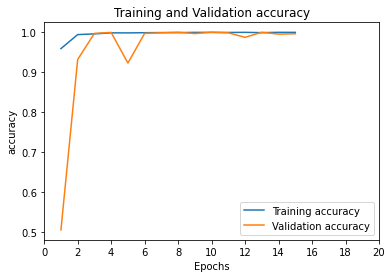

In [29]:
from pickle import load
from matplotlib.pylab import plt
from numpy import arange

# Load the training and validation loss dictionaries
train_values = history_1.history['accuracy']
val_values = history_1.history['val_accuracy']

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 16)
 
# Plot and label the training and validation loss values
plt.plot(epochs, train_values, label='Training accuracy')
plt.plot(epochs, val_values, label='Validation accuracy')
 
# Add in a title and axes labels
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
 
# Set the tick locations
plt.xticks(arange(0, 21, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

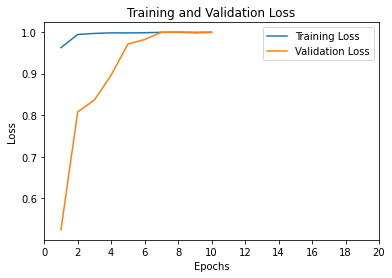

In [100]:
from pickle import load
from matplotlib.pylab import plt
from numpy import arange

# Load the training and validation loss dictionaries
train_values = history_4.history['accuracy']
val_values = history_4.history['val_accuracy']

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 11)
 
# Plot and label the training and validation loss values
plt.plot(epochs, train_values, label='Training Loss')
plt.plot(epochs, val_values, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 21, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

## Testing


In [28]:
image = [read_image(im) for im in train_x[20:40]]
image[0].shape

TensorShape([256, 256, 3])

In [29]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset.batch(BATCH_SIZE).prefetch(3))

# Predict on the test dataset
predictions = model.predict(test_dataset.batch(BATCH_SIZE).prefetch(3))
predicted_labels = np.round(predictions).flatten()

# Get the true labels for the test dataset
true_labels = np.array([label.numpy().item() for _, label in test_dataset])

# Calculate metrics on the test dataset
test_f1 = f1_score(true_labels, predicted_labels)
test_precision = precision_score(true_labels, predicted_labels)
test_recall = recall_score(true_labels, predicted_labels)

# Print the metrics
print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)


115/115 [==============================] - 23s 197ms/step - loss: 0.0415 - accuracy: 0.9872
Test Accuracy: 0.9871655106544495
Test F1 Score: 0.9874163319946452
Test Precision: 0.9792883696229421
Test Recall: 0.9956803455723542


In [69]:

# Function to display the image and labels
def display_image_with_labels(image, real_label, predicted_label):
    plt.imshow(image)
    plt.title(f"Real Label: {real_label}, Predicted Label: {predicted_label:.2f}")
    plt.show()

def display_model(model, test_dataset):
    # Predict on the validation dataset
    predictions = model.predict(test_dataset.batch(BATCH_SIZE).prefetch(3))
    predicted_labels = np.round(predictions).flatten()

    # # Loop over each image, real label, and predicted label
    for i, (image, real_label) in enumerate(test_dataset.take(len(predicted_labels))):
        predicted_label = predicted_labels[i]

        # Convert the image tensor to a NumPy array for display
        image_np = image.numpy()

        # Convert real_label to a scalar value (assuming it's a single-element tensor)
        real_label = real_label.numpy().item()

        # Display the image with the real label and predicted label
        display_image_with_labels(image_np, real_label, predicted_label)


In [71]:
def get_dataset():
    test_dataset = tf.data.Dataset.from_generator(
            lambda : generator(test_x, test_y),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32)
            )
    )
    return test_dataset

In [52]:
# test = get_dataset()
# display_model(model_1, test)

In [51]:
# test = get_dataset()
# display_model(model_2, test)

In [ ]:
test = get_dataset()
display_model(model_3, test)

In [ ]:
test = get_dataset()
display_model(model_4, test)

In [ ]:
test = get_dataset()
display_model(model_5, test)

In [53]:
all_loss = loss_1 + loss_2 + loss_3 + loss_4 + loss_5
all_acc = accuracy_1 + accuracy_2 + accuracy_3 + accuracy_4 + accuracy_5
print(f"Average loss : {all_loss / 5}")
print(f"Average Accuracy : {all_acc / 5}")

Average loss : 0.14069488134700806
Average Accuracy : 0.9011799454689026


In [101]:
sum([accuracy_1 ,accuracy_2 ,accuracy_3 ,accuracy_4, accuracy_5]) / 5

0.9986476302146912

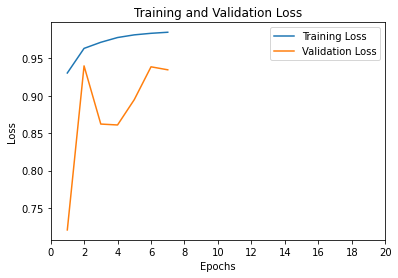

In [65]:
from pickle import load
from matplotlib.pylab import plt
from numpy import arange

# Load the training and validation loss dictionaries
train_values = history_3.history['accuracy']
val_values = history_3.history['val_accuracy']

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 8)
 
# Plot and label the training and validation loss values
plt.plot(epochs, train_values, label='Training Loss')
plt.plot(epochs, val_values, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 21, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

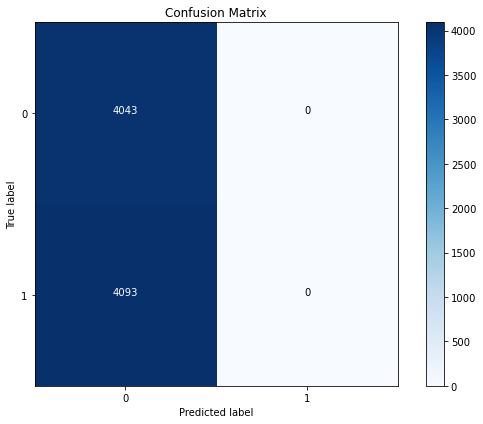

In [66]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools

predictions = model_1.predict(test_dataset.batch(BATCH_SIZE).prefetch(3))
predicted_labels = np.round(predictions).flatten() 


cm = confusion_matrix(predicted_labels, np.argmax(predictions, axis=1))

class_labels = [0, 1]

# Plot confusion matrix as a heatmap using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels to the axes
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)

# Display values in the cells
thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()
